# [E4] 4th project NAVER Movie Review
1. 네이버리뷰
 - 데이터 전처리
 - LSTM (RNN)
 - CNN
 - MaxPooling
2. gensim Word2Vec 불러오기 
3. Word2Vec 학습하기
4. 결론


# 1. 네이버 리뷰

In [1]:
# 패키지를 불러오기
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras.initializers import Constant
from konlpy.tag import Mecab

from gensim.models import KeyedVectors
import os
import gensim

In [2]:
# 데이터를 읽어봅시다. 네이버리뷰 미리 다운받은 데이터
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

print('테스트용 리뷰 개수 :',len(test_data)) # 테스트용 리뷰 개수 출력
print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력

# 데이터를 몇개만 출력해보자
train_data.head() # 훈련용 데이터 헤드 

테스트용 리뷰 개수 : 50000
훈련용 리뷰 개수 : 150000


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [3]:
# 훈련용 데이터 document와 label 개수를 호가인해보자.
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

In [4]:
# 데이터 중복 확인
#훈련용 데이터 150000 개 중에 146182를 뺀 3818개가 document에서 중복
#훈련용 데이터 labeL 0과 1만 가지므로 2가 출력됨. 
train_data.drop_duplicates(subset=['document'], inplace=True) 
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 146183


In [5]:
# 데이터 중복 제거
#document 열에서 중복인 내용 제거 후 총 샘플 수 확인
# null값 확인
print(train_data.isnull().values.any())
print(train_data.isnull().sum())
train_data.loc[train_data.document.isnull()]
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인
print(len(train_data))

train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())
train_data = train_data.dropna(how = 'any')
print(len(train_data))

True
id          0
document    1
label       0
dtype: int64
False
146182
id          0
document    0
label       0
dtype: int64
146182


In [6]:
#train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# 한글과 공백을 제외하고 모두 제거
#train_data[:5]

In [7]:
# 테스트 데이터도 동일하게 제거를 하자
#test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
#test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
#test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
#test_data = test_data.dropna(how='any') # Null 값 제거
#print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

In [8]:

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(X_train), len(X_test)))

훈련 샘플 개수: 146182, 테스트 개수: 49157


In [9]:
train_data[:5]

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 빈샘플 제거

In [10]:
#drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

# 빈 샘플들을 제거
#X_train = np.delete(X_train, drop_train, axis=0)
#y_train = np.delete(y_train, drop_train, axis=0)

#print(len(X_train))
#print(len(y_train))

# 패딩

리뷰의 최대 길이 : 116
리뷰의 평균 길이 : 15.981694052619337


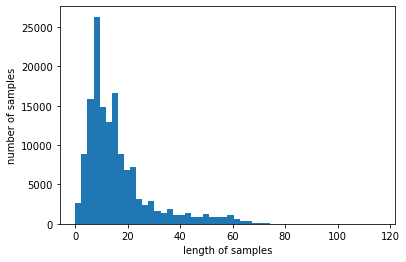

전체 샘플 중 길이가 30 이하인 샘플의 비율: 88.54510131206304


In [11]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

max_len = 30
below_threshold_len(max_len, X_train)

X_train = pad_sequences(X_train, padding='pre', maxlen = max_len)
X_test = pad_sequences(X_test, padding='pre', maxlen = max_len)

index_to_word = {index:word for word, index in word_to_index.items()}


# LSTM 분류하기

In [12]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어), 위에서 사이즈가 정해져 있으므로 생략
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model_LSTM = Sequential()
model_LSTM.add(Embedding(vocab_size, word_vector_dim))
model_LSTM.add(LSTM(64))
model_LSTM.add(Dense(8, activation='relu'))
model_LSTM.add(Dense(1, activation='sigmoid'))
model_LSTM.summary()

epochs=15

model_LSTM.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
# validation 0.2 (20%설정)
history = model_LSTM.fit(X_train, y_train, epochs=epochs, batch_size=60, validation_split=0.2)

results = model_LSTM.evaluate(X_test,  y_test, verbose=2)
print(results)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                20736     
_________________________________________________________________
dense (Dense)                (None, 8)                 520       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 181,265
Trainable params: 181,265
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
1950/1950 [==============================] - 7s 4ms/step - loss: 0.4071 - accuracy: 0.8139 - val_loss: 0.3788 - val_accuracy: 0.8308
Epoch 2/15
1950/1950 [==============================] - 7s 3ms/step - loss: 0.3395 - accuracy: 0.8528 - 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


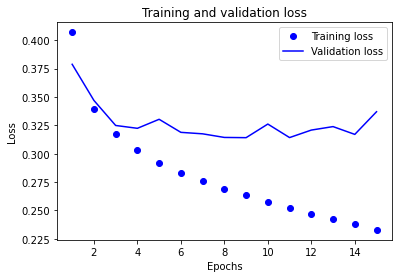

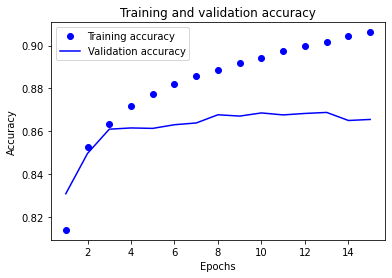

In [13]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 학습된 임베딩 벡터 저장

In [14]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/ko/word2vec_ko_LSTM.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.
#vocab_size

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_LSTM.get_weights()[0]
for i in range(4,vocab_size): #vocab_size
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
word_vectors.similar_by_word("사랑")

[('귀여운', 0.9838551878929138),
 ('젊', 0.9715663194656372),
 ('위트', 0.9704916477203369),
 ('기발', 0.9695026874542236),
 ('알파치노', 0.9683853387832642),
 ('통쾌', 0.9683669209480286),
 ('울', 0.96725994348526),
 ('웰메이드', 0.9660279154777527),
 ('귀엽', 0.9641057848930359),
 ('만점', 0.9633206129074097)]

# 사전학습 데이터 활용

In [15]:
from gensim.models import KeyedVectors
import os
import gensim

ko_model = gensim.models.Word2Vec.load('~/aiffel/ko/ko.bin')
word2vec = ko_model
word2vec.similar_by_word("사랑")

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  import sys


[('슬픔', 0.7216663360595703),
 ('행복', 0.6759077310562134),
 ('절망', 0.6468985676765442),
 ('기쁨', 0.6458414793014526),
 ('이별', 0.6334798336029053),
 ('추억', 0.6320937871932983),
 ('인생', 0.6216273307800293),
 ('애정', 0.6206068992614746),
 ('연인', 0.6186063289642334),
 ('유혹', 0.5965287685394287)]

# LSTM + 사전학습 word2vec

In [17]:
#vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]
        
print("ok")

ok


/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [18]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어), 위에서 사이즈가 정해져 있으므로 생략
word_vector_dim = 200  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model_LSTM_plus = Sequential()
model_LSTM_plus.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=max_len, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_LSTM_plus.add(LSTM(64))
model_LSTM_plus.add(Dense(8, activation='relu'))
model_LSTM_plus.add(Dense(1, activation='sigmoid'))
model_LSTM_plus.summary()

epochs=15

model_LSTM_plus.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
# validation 0.2 (20%설정)
history = model_LSTM_plus.fit(X_train, y_train, epochs=epochs, batch_size=60, validation_split=0.2)

results = model_LSTM_plus.evaluate(X_test,  y_test, verbose=2)
print(results)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 200)           2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                67840     
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 2,068,369
Trainable params: 2,068,369
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
1950/1950 [==============================] - 17s 9ms/step - loss: 0.4162 - accuracy: 0.8064 - val_loss: 0.3668 - val_accuracy: 0.8402
Epoch 2/15
1950/1950 [==============================] - 17s 9ms/step - loss: 0.3236 - accuracy: 0

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


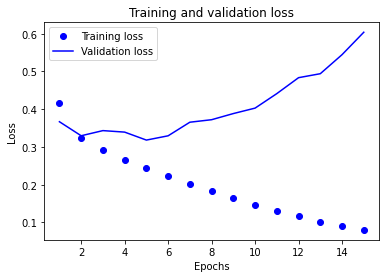

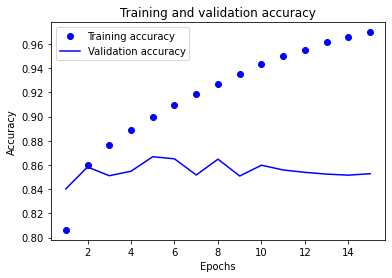

In [19]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [20]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/ko/word2vec_ko_LSTM_plus.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.
#vocab_size

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_LSTM_plus.get_weights()[0]
for i in range(4,vocab_size): #vocab_size
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
word_vectors.similar_by_word("사랑")

[('슬픔', 0.7239742279052734),
 ('행복', 0.6869573593139648),
 ('기쁨', 0.671248197555542),
 ('애정', 0.6358910799026489),
 ('존경', 0.6127861738204956),
 ('인생', 0.6104490756988525),
 ('연인', 0.6098191738128662),
 ('즐거움', 0.6093759536743164),
 ('마음', 0.609087347984314),
 ('감동', 0.5956058502197266)]

# CNN 분류하기


In [21]:
vocab_size = 10000
word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model_CNN = keras.Sequential()
model_CNN.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_CNN.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_CNN.add(keras.layers.MaxPooling1D(5))
model_CNN.add(keras.layers.Dense(8, activation='relu'))
model_CNN.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_CNN.summary()

model_CNN.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model_CNN.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_split=0.2, 
                    verbose=1)
results = model_CNN.evaluate(X_test,  y_test, verbose=2)
print(results)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
dense_4 (Dense)              (None, None, 8)           136       
_________________________________________________________________
dense_5 (Dense)              (None, None, 1)           9         
Total params: 161,953
Trainable params: 161,953
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
914/914 [==============================] - 9s 9ms/step - loss: 0.6154 - accuracy: 0.6149 - val_loss: 0.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


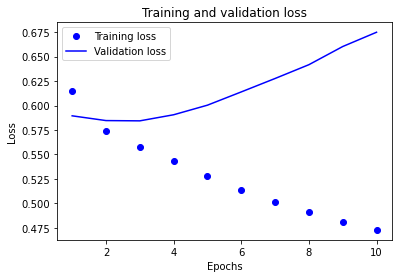

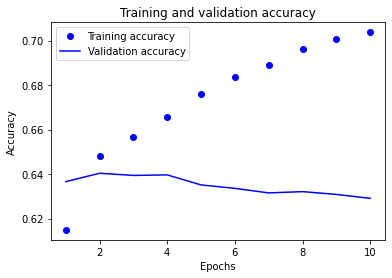

In [22]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [23]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/ko/word2vec_ko_CNN.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.
#vocab_size

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_CNN.get_weights()[0]
for i in range(4,vocab_size): #vocab_size
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
word_vectors.similar_by_word("사랑")

[('넘쳤', 0.9054323434829712),
 ('운적', 0.8874784111976624),
 ('보냅니다', 0.8776174783706665),
 ('뒤돌아보', 0.8765003681182861),
 ('봉준호', 0.8719667196273804),
 ('나무랄', 0.8712939023971558),
 ('편도', 0.8626317381858826),
 ('강렬', 0.8581732511520386),
 ('^-^', 0.8524709939956665),
 ('훈훈', 0.8521831035614014)]

# CNN + 사전학습 데이터 분류기

In [24]:
vocab_size = 10000
word_vector_dim = 200   # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model_CNN_plus = keras.Sequential()
model_CNN_plus.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=max_len, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_CNN_plus.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_CNN_plus.add(keras.layers.MaxPooling1D(5))
model_CNN_plus.add(keras.layers.Dense(8, activation='relu'))
model_CNN_plus.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_CNN_plus.summary()

model_CNN_plus.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model_CNN_plus.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_split=0.2, 
                    verbose=1)
results = model_CNN_plus.evaluate(X_test,  y_test, verbose=2)
print(results)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 30, 200)           2000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 24, 16)            22416     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 4, 16)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 4, 8)              136       
_________________________________________________________________
dense_7 (Dense)              (None, 4, 1)              9         
Total params: 2,022,561
Trainable params: 2,022,561
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
914/914 [==============================] - 20s 22ms/step - loss: 0.6399 - accuracy: 0.5953 - val_lo

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


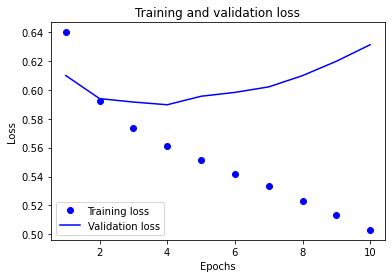

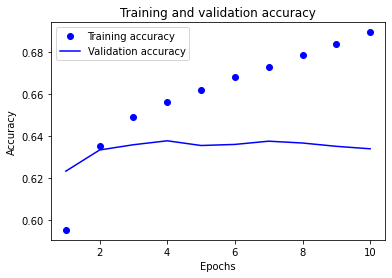

In [25]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [26]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/ko/word2vec_ko_CNN_plus.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.
#vocab_size

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_CNN_plus.get_weights()[0]
for i in range(4,vocab_size): #vocab_size
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
word_vectors.similar_by_word("사랑")

[('슬픔', 0.7173073291778564),
 ('행복', 0.6646480560302734),
 ('연인', 0.6367336511611938),
 ('이별', 0.6295158863067627),
 ('추억', 0.6253029108047485),
 ('절망', 0.6233916878700256),
 ('애정', 0.6231517791748047),
 ('기쁨', 0.6183872222900391),
 ('인생', 0.6107255220413208),
 ('유혹', 0.581893801689148)]

# GlobalMaxPooling1D

In [27]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 8   # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model_global = keras.Sequential()
model_global.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_global.add(keras.layers.GlobalMaxPooling1D())
model_global.add(keras.layers.Dense(8, activation='relu'))
model_global.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_global.summary()

model_global.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model_global.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_split=0.2, 
                    verbose=1)
results = model_global.evaluate(X_test,  y_test, verbose=2)
print(results)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 8)           80000     
_________________________________________________________________
global_max_pooling1d (Global (None, 8)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 80,081
Trainable params: 80,081
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
914/914 [==============================] - 2s 3ms/step - loss: 0.4863 - accuracy: 0.7673 - val_loss: 0.3851 - val_accuracy: 0.8298
Epoch 2/10
914/914 [==============================] - 2s 2ms/step - loss: 0.3515 - accuracy: 0.8477 - val_

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


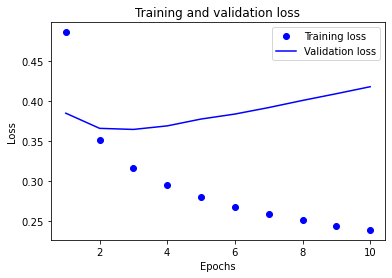

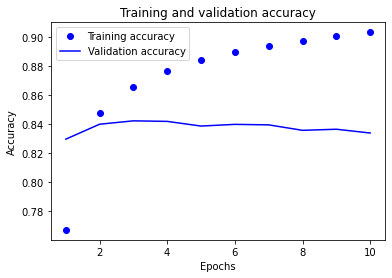

In [28]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [29]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/ko/word2vec_ko_Global.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.
#vocab_size

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_global.get_weights()[0]
for i in range(4,vocab_size): #vocab_size
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
word_vectors.similar_by_word("사랑")

[('자유', 0.9734324216842651),
 ('스캔들', 0.9704996943473816),
 ('넘치', 0.9612266421318054),
 ('여태', 0.9608643054962158),
 ('번', 0.9585793018341064),
 ('쿠', 0.9554920196533203),
 ('스물', 0.9526336789131165),
 ('디카프리오', 0.9463655948638916),
 ('쇼생크', 0.9429834485054016),
 ('박수', 0.9425299167633057)]

In [30]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]
        
print("ok")

ok


/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [31]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 200   # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model_global_plus = keras.Sequential()
model_global_plus.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=max_len, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_global_plus.add(keras.layers.GlobalMaxPooling1D())
model_global_plus.add(keras.layers.Dense(8, activation='relu'))
model_global_plus.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_global_plus.summary()

model_global_plus.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model_global_plus.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_split=0.2, 
                    verbose=1)
results = model_global_plus.evaluate(X_test,  y_test, verbose=2)
print(results)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 30, 200)           2000000   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 200)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 1608      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 2,001,617
Trainable params: 2,001,617
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
914/914 [==============================] - 15s 17ms/step - loss: 0.6045 - accuracy: 0.6636 - val_loss: 0.5138 - val_accuracy: 0.7492
Epoch 2/10
914/914 [==============================] - 15s 16ms/step - loss: 0.4735 - accuracy: 0.7

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


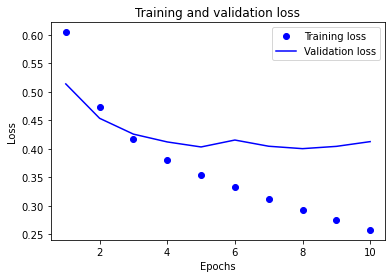

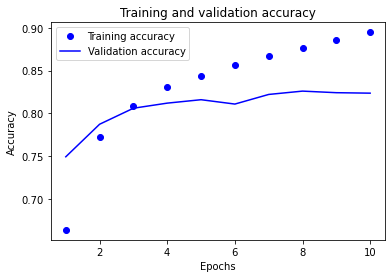

In [32]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [33]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/ko/word2vec_ko_Global_plus.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.
#vocab_size

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_global_plus.get_weights()[0]
for i in range(4,vocab_size): #vocab_size
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
word_vectors.similar_by_word("사랑")

[('슬픔', 0.726982593536377),
 ('행복', 0.6647186875343323),
 ('절망', 0.6428117752075195),
 ('기쁨', 0.6423717737197876),
 ('이별', 0.6325733661651611),
 ('추억', 0.6321818828582764),
 ('인생', 0.6172713041305542),
 ('연인', 0.61249178647995),
 ('애정', 0.6041457653045654),
 ('유혹', 0.6029502153396606)]

# 결과정리

In [34]:

word2vec_LSTM_file_path = os.getenv('HOME')+'/aiffel/ko/word2vec_ko_LSTM.txt'
word2vec_LSTM_plus_file_path = os.getenv('HOME')+'/aiffel/ko/word2vec_ko_LSTM_plus.txt'
word2vec_CNN_file_path = os.getenv('HOME')+'/aiffel/ko/word2vec_ko_CNN.txt'
word2vec_CNN_plus_file_path = os.getenv('HOME')+'/aiffel/ko/word2vec_ko_CNN_plus.txt'
word2vec_Global_file_path = os.getenv('HOME')+'/aiffel/ko/word2vec_ko_Global.txt'
word2vec_Global_plus_file_path = os.getenv('HOME')+'/aiffel/ko/word2vec_ko_Global_plus.txt'
print("-------------LSTM-------------")
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_LSTM_file_path, binary=False)
print(word_vectors.similar_by_word("사랑"))
print("---------------------------")
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_LSTM_plus_file_path, binary=False)
print(word_vectors.similar_by_word("사랑"))
print("-------------CNN-------------")
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_CNN_file_path, binary=False)
print(word_vectors.similar_by_word("사랑"))
print("---------------------------")
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_CNN_plus_file_path, binary=False)
print(word_vectors.similar_by_word("사랑"))
print("-------------Global-------------")
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_Global_file_path, binary=False)
print(word_vectors.similar_by_word("사랑"))
print("---------------------------")
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_Global_plus_file_path, binary=False)
print(word_vectors.similar_by_word("사랑"))

-------------LSTM-------------
[('귀여운', 0.9838551878929138), ('젊', 0.9715663194656372), ('위트', 0.9704916477203369), ('기발', 0.9695026874542236), ('알파치노', 0.9683853387832642), ('통쾌', 0.9683669209480286), ('울', 0.96725994348526), ('웰메이드', 0.9660279154777527), ('귀엽', 0.9641057848930359), ('만점', 0.9633206129074097)]
---------------------------
[('슬픔', 0.7239742279052734), ('행복', 0.6869573593139648), ('기쁨', 0.671248197555542), ('애정', 0.6358910799026489), ('존경', 0.6127861738204956), ('인생', 0.6104490756988525), ('연인', 0.6098191738128662), ('즐거움', 0.6093759536743164), ('마음', 0.609087347984314), ('감동', 0.5956058502197266)]
-------------CNN-------------
[('넘쳤', 0.9054323434829712), ('운적', 0.8874784111976624), ('보냅니다', 0.8776174783706665), ('뒤돌아보', 0.8765003681182861), ('봉준호', 0.8719667196273804), ('나무랄', 0.8712939023971558), ('편도', 0.8626317381858826), ('강렬', 0.8581732511520386), ('^-^', 0.8524709939956665), ('훈훈', 0.8521831035614014)]
---------------------------
[('슬픔', 0.7173073291778564), ('행복

# 4. 결론


자연어 처리에서 RNN, CNN, Maxpooling 모델을 통해서 결과를 확인해보았다.
결과는 예상대로 RNN이 가장 높은 성능을 보여주었고 CNN의 경우는 다소 학습이 안되는 결과로 보여졌다.
- LSTM - loss: 0.3420 - accuracy: 0.8599
- CNN - loss: 0.6793 - accuracy: 0.6292
- Maxpooling - loss: 0.4288 - accuracy: 0.8313

다음 사전학습된 임베딩 벡터파일을 통해서 성능을 향상시켜볼 수 있었다. 일반적으로 2% 성능향상이 있다고 하지만
모델구성에 따라 다소 편차가 있는것같다. 
- LSTM plus - loss: 0.6144 - accuracy: 0.8500
- CNN plus - loss: 0.6382 - accuracy: 0.6338
- Maxpooling plus - loss: 0.4170 - accuracy: 0.8224

LSTM은 Long Short-Term Memory는 RNN에서 forget gate를 추가한것으로 RNN의 일종으로 모델을 구성하였다.
자연어처리에서 전단계의 과거 학습 데이터를 재귀 시키는 형태로서, 이전의 값을 메모리 형태로 기억되어 순차적인 데이터열 처리에 적합함을 확인할 수 있었다. 

gensim으로 학습된 word2vec 모델과 비교를 하였고 자체학습 된 모델과 word2vec 없이 학습된 모델과 비교하였다.
